## Imports

In [20]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from prettytable import PrettyTable

## 3.1

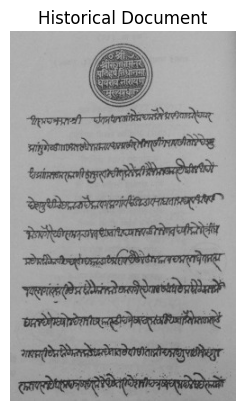

+-------------+-------+
|   Property  | Value |
+-------------+-------+
| Height (px) |  411  |
|  Width (px) |  251  |
|  Red (Min)  |   28  |
|  Red (Max)  |  190  |
| Green (Min) |   28  |
| Green (Max) |  190  |
|  Blue (Min) |   28  |
|  Blue (Max) |  190  |
+-------------+-------+


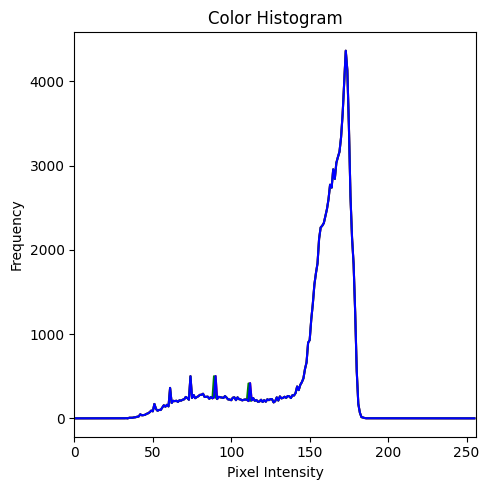

In [21]:
def load_document_image(img_path="historical_doc.png"):
    historical_doc_img_bgr = cv2.imread(img_path)
    historical_doc_img_rgb = cv2.cvtColor(historical_doc_img_bgr, cv2.COLOR_BGR2RGB)
    return historical_doc_img_rgb

historical_doc_img = load_document_image()

# Display the image
plt.imshow(historical_doc_img)
plt.title("Historical Document")
plt.axis("off")
plt.show()

# Printing basic information about it
h, w, c = historical_doc_img.shape

# Calculate min and max pixel values for each channel
r_min_px = historical_doc_img[:, :, 0].min()
r_max_px = historical_doc_img[:, :, 0].max()
g_min_px = historical_doc_img[:, :, 1].min()
g_max_px = historical_doc_img[:, :, 1].max()
b_min_px = historical_doc_img[:, :, 2].min()
b_max_px = historical_doc_img[:, :, 2].max()

# Create and populate the table
table = PrettyTable()
table.field_names = ["Property", "Value"]

table.add_row(["Height (px)", h])
table.add_row(["Width (px)", w])
table.add_row(["Red (Min)", r_min_px])
table.add_row(["Red (Max)", r_max_px])
table.add_row(["Green (Min)", g_min_px])
table.add_row(["Green (Max)", g_max_px])
table.add_row(["Blue (Min)", b_min_px])
table.add_row(["Blue (Max)", b_max_px])

# Print the table
print(table)

colors = ('r', 'g', 'b')

# Create a new figure for side-by-side comparison
fig, axes = plt.subplots(1, 1, figsize=(5, 5))

# My Histogram
axes.set_title("Color Histogram")
axes.set_xlabel("Pixel Intensity")
axes.set_ylabel("Frequency")
axes.set_xlim([0, 256])

for channel in range(historical_doc_img.shape[2]):  # Iterate through RGB channels
    channel_arr = historical_doc_img[:, :, channel]
    hist = np.zeros(256)
    for i in range(256):
        hist[i] = np.sum(channel_arr == i)
    axes.plot(hist, color=colors[channel])

# Display the figure
plt.tight_layout()
plt.show()

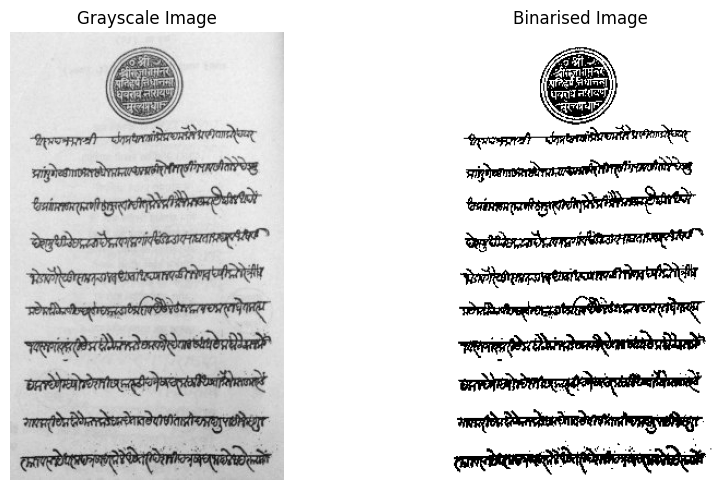

In [22]:
def preprocess_image(img, binarising_threshold=128):
    titles = ["Grayscale Image", "Binarised Image"]
    images = list()

    grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    binarised_img = np.where(grayscale_img > binarising_threshold, 255, 0)
    binarised_img = np.astype(binarised_img, np.uint8)

    images.append(grayscale_img)
    images.append(binarised_img)

    return images, titles

images, titles = preprocess_image(historical_doc_img)
preprocessed_img = images[-1]

fig, ax = plt.subplots(1, len(images), figsize=(10, 5))
for idx, title_img_tuple in enumerate(zip(titles, images)):
    title, image = title_img_tuple
    ax[idx].imshow(image, cmap="gray")
    ax[idx].set_title(title)
    ax[idx].axis("off")

plt.tight_layout()
plt.show()

> I first converted the image to grayscale as the color was of no use to detect lines and then binarised the image to obtain a clear distinction between text and background which will make it easier for the algorithm to detect lines.

> I used the binarisation threshold as 128 as it was giving clear distinction between the foreground and background (by hit and trial).

> If some lower or higher values were being used a lot of noise was getting included in the image or the text was getting lost which will again lead to false and erronous detection.

# 3.2

Number of circles detected = 1


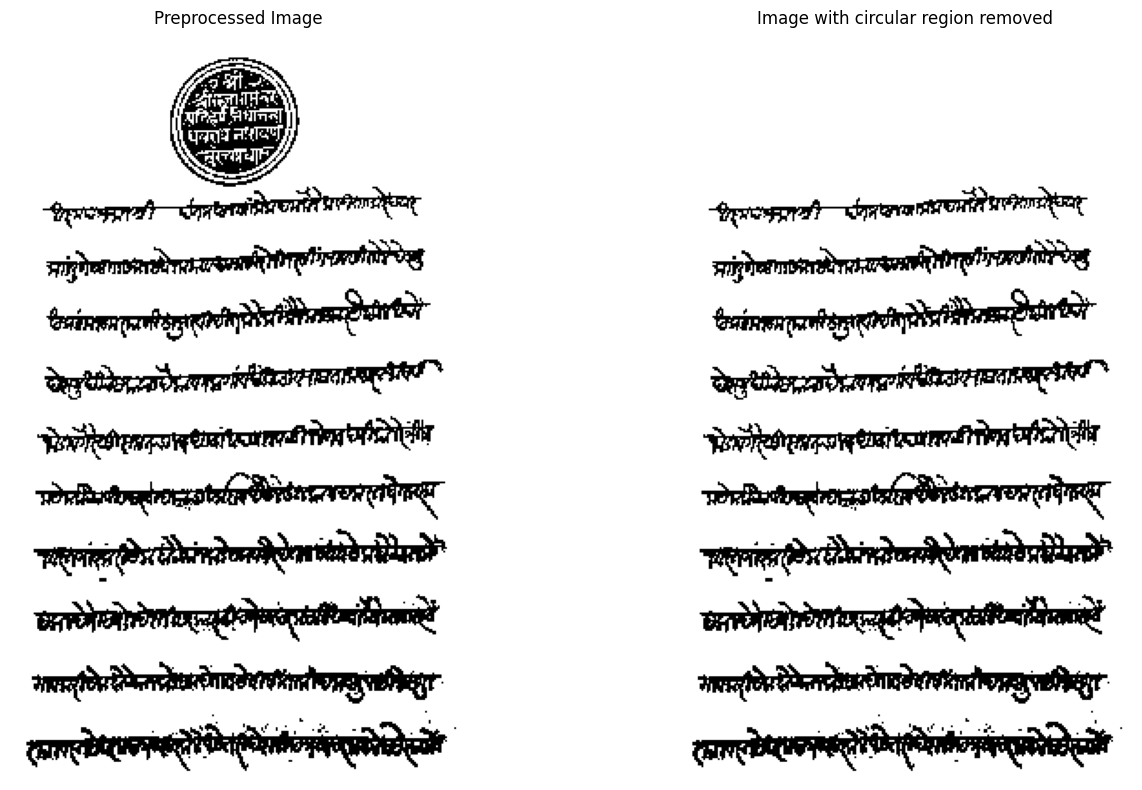

In [23]:
def detect_circles(preprocessed_img, k=3, dp=1.2, min_dist=40, param1=50, param2=30, min_radius=20, max_radius=40):
    if len(preprocessed_img.shape) == 3:
        gray_img = cv2.cvtColor(preprocessed_img, cv2.COLOR_RGB2GRAY)
    else:
        gray_img = np.copy(preprocessed_img)

    # Blur image for better detection
    blurred_img = cv2.GaussianBlur(gray_img, (k, k), 0)

    # Detect circles
    circles = cv2.HoughCircles(
        blurred_img,
        cv2.HOUGH_GRADIENT,
        dp=dp,              # Inverse ratio of accumulator resolution to image resolution
        minDist=min_dist,   # Minimum distance between detected circle centers
        param1=param1,      # High threshold for Canny edge detector
        param2=param2,      # Threshold for center detection
        minRadius=min_radius,
        maxRadius=max_radius
    )

    return circles, len(circles[0])

def clear_regions(img, regions):
    # Create a copy of the input image for modification
    output_img = np.copy(img)

    if regions is not None:
        regions = np.uint16(np.around(regions))
        for i in regions[0, :]:
            center_x, center_y, radius = i[0], i[1], i[2] + 10 # adding 10 to radius to remove the artifacts that were remaining

            # Create a mask with the same dimensions as the image
            mask = np.zeros_like(img, dtype=np.uint8)

            # Draw a filled circle (mask) corresponding to the detected circle
            cv2.circle(mask, (center_x, center_y), radius, 255, thickness=-1)

            # Change pixels inside the circle to white in the output image
            output_img[mask == 255] = [255]  # White color

    return output_img

# Detecting the circular seal on the document
circles, n_circles = detect_circles(preprocessed_img)

print(f"Number of circles detected = {n_circles}")

# Clearing out that region of the circular seal from the image
cleared_img = clear_regions(preprocessed_img, circles)

fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].axis("off")
ax[0].set_title("Preprocessed Image")
ax[0].imshow(preprocessed_img, cmap="gray")

ax[1].axis("off")
ax[1].set_title("Image with circular region removed")
ax[1].imshow(cleared_img, cmap="gray")

plt.tight_layout()
plt.show()

In [24]:
# Function to detect lines
def detect_text_lines(binary_img, min_line_height=5, th=1):
    inverted_binary_img = np.where(binary_img == 255, 0, 1)

    # Calculate horizontal projection profile
    horizontal_projection = np.sum(inverted_binary_img, axis=1)

    # Find text lines using the projection profile
    lines = []
    line_start = None

    # Detect row boundaries
    for y in range(len(horizontal_projection)):
        if horizontal_projection[y] >= th and line_start is None:
            line_start = y
        elif horizontal_projection[y] < th and line_start is not None:
            line_end = y
            if line_end - line_start >= min_line_height:
                # Find column boundaries only within the row range
                line_image = inverted_binary_img[line_start:line_end, :]
                x_projection = np.sum(line_image, axis=0)

                # Find leftmost text pixel
                x_start = None
                x_end = None
                for x in range(len(x_projection)):
                    if x_projection[x] > 0 and x_start is None:
                        x_start = x
                    if x_projection[x] > 0:
                        x_end = x

                if x_start is not None and x_end is not None:
                    # Add padding to the box
                    padding = 2
                    x_start = max(0, x_start - padding)
                    x_end = min(binary_img.shape[1], x_end + padding)
                    y_start = max(0, line_start - padding)
                    y_end = min(binary_img.shape[0], line_end + padding)

                    lines.append((y_start, y_end, x_start, x_end))
            line_start = None

    return lines

# Function to draw the bounding boxes on the image
def draw_bounding_boxes(img, lines):
    final_image = img.copy()
    if len(final_image.shape) == 2:
        final_image = cv2.cvtColor(final_image, cv2.COLOR_GRAY2RGB)
    for y_start, y_end, x_start, x_end in lines:
        # Draw rectangle around text line
        cv2.rectangle(final_image, 
                        (x_start, y_start), 
                        (x_end, y_end), 
                        (0, 255, 0),    # Green color
                        1)              # Line thickness
    return final_image

# Function to print line positions
def print_line_positions(lines):
    print(f"Found {len(lines)} text lines:")
    for i, (y_start, y_end, x_start, x_end) in enumerate(lines, 1):
        print(f"Line {i}: Box coordinates - Top: {y_start}, Bottom: {y_end}, Left: {x_start}, Right: {x_end}")
        print(f"        Box dimensions - Width: {x_end-x_start}, Height: {y_end-y_start}")

Found 10 text lines:
Line 1: Box coordinates - Top: 83, Bottom: 110, Left: 16, Right: 227
        Box dimensions - Width: 211, Height: 27
Line 2: Box coordinates - Top: 112, Bottom: 140, Left: 18, Right: 229
        Box dimensions - Width: 211, Height: 28
Line 3: Box coordinates - Top: 139, Bottom: 172, Left: 18, Right: 232
        Box dimensions - Width: 214, Height: 33
Line 4: Box coordinates - Top: 178, Bottom: 204, Left: 17, Right: 239
        Box dimensions - Width: 222, Height: 26
Line 5: Box coordinates - Top: 209, Bottom: 237, Left: 13, Right: 234
        Box dimensions - Width: 221, Height: 28
Line 6: Box coordinates - Top: 240, Bottom: 270, Left: 12, Right: 240
        Box dimensions - Width: 228, Height: 30
Line 7: Box coordinates - Top: 271, Bottom: 301, Left: 11, Right: 241
        Box dimensions - Width: 230, Height: 30
Line 8: Box coordinates - Top: 307, Bottom: 337, Left: 11, Right: 237
        Box dimensions - Width: 226, Height: 30
Line 9: Box coordinates - Top: 344, 

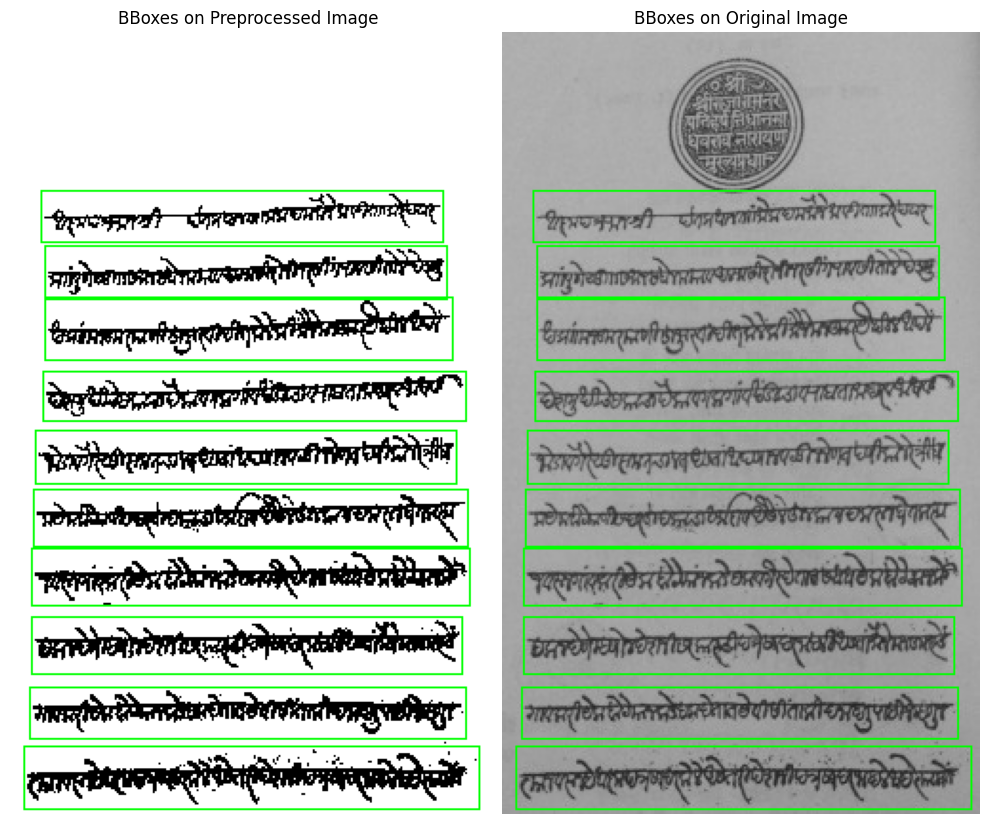

In [25]:
lines_main_text = detect_text_lines(cleared_img)

# Draw bounding boxes on the preprocessed image
result_image_preprocessed = draw_bounding_boxes(cleared_img, lines_main_text)

# Draw bounding boxes on the original image
result_image_original = draw_bounding_boxes(historical_doc_img, lines_main_text)

line_images = []
for i, (y_start, y_end, x_start, x_end) in enumerate(lines_main_text, 1):
    line_image = historical_doc_img[y_start:y_end, x_start:x_end]
    line_images.append(line_image)
    filename = f"Output/line_{i}.png"
    cv2.imwrite(filename, line_image)

print_line_positions(lines_main_text)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(result_image_preprocessed)
ax[0].set_title("BBoxes on Preprocessed Image")
ax[0].axis("off")

ax[1].imshow(result_image_original)
ax[1].set_title("BBoxes on Original Image")
ax[1].axis("off")

plt.tight_layout()
plt.show()

> The algorithm works pretty good in detecting the lines and in O(n) complexity, but it will only work for the cases when there is a clear distinction between subsequent lines of text or else it the space is less it might consider two different lines as one. It also depends on the number of black pixels that you consider as your threshold to be an empty row of pixels as the algorithm detects line spaces and not exactly text lines.

Found 5 text lines:
Line 1: Box coordinates - Top: 25, Bottom: 32, Left: 103, Right: 140
        Box dimensions - Width: 37, Height: 7
Line 2: Box coordinates - Top: 30, Bottom: 42, Left: 96, Right: 148
        Box dimensions - Width: 52, Height: 12
Line 3: Box coordinates - Top: 40, Bottom: 51, Left: 94, Right: 151
        Box dimensions - Width: 57, Height: 11
Line 4: Box coordinates - Top: 50, Bottom: 62, Left: 96, Right: 151
        Box dimensions - Width: 55, Height: 12
Line 5: Box coordinates - Top: 62, Bottom: 72, Left: 100, Right: 143
        Box dimensions - Width: 43, Height: 10


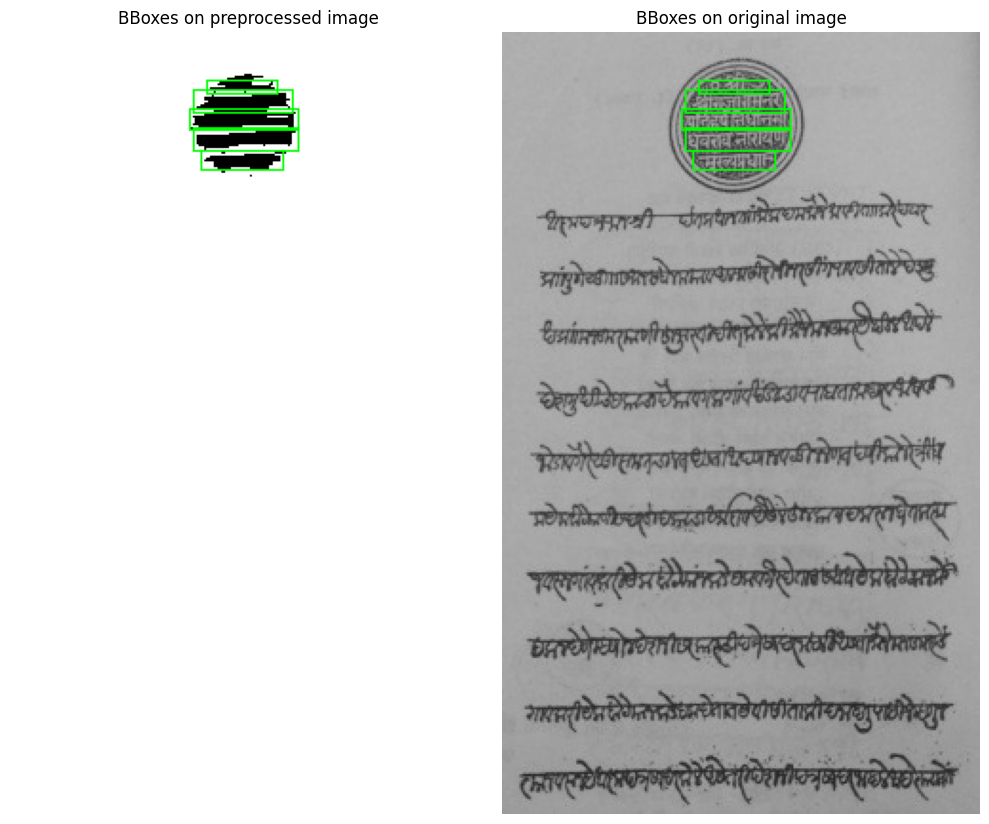

In [26]:
def save_regions(img, regions):
    # Create a copy of the input image for modification
    output_img = np.copy(img)

    if regions is not None:
        regions = np.uint16(np.around(regions))
        for i in regions[0, :]:
            center_x, center_y, radius = i[0], i[1], i[2] - 6 # subtracting 6 to radius to remove the artifacts that were remaining

            # Create a mask with the same dimensions as the image
            mask = np.zeros_like(img, dtype=np.uint8)

            # Draw a filled circle (mask) corresponding to the detected circle
            cv2.circle(mask, (center_x, center_y - 1), radius - 1, 255, thickness=-1)

            # Change pixels inside the circle to white in the output image
            output_img[mask == 0] = [0] # Color inversion and removing all the area except the seal part

    return output_img

saved_img = save_regions(preprocessed_img, circles)

inverted_img = np.astype(np.where(saved_img == 255, 0, 255), np.float32)

# Performing opening as an additional preprocessing step to obtain better results for the circular region
kernel_size = (9, 1)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
opened_img = cv2.morphologyEx(inverted_img, cv2.MORPH_OPEN, kernel)

lines_seal_text = detect_text_lines(inverted_img, min_line_height=2, th=12)

result_image_circle_preprocessed = draw_bounding_boxes(opened_img, lines_seal_text)

result_image_circle_original = draw_bounding_boxes(historical_doc_img, lines_seal_text)

# Save each detected line as a separate image
line_images = []
for i, (y_start, y_end, x_start, x_end) in enumerate(lines_seal_text, 1):
    line_image = historical_doc_img[y_start:y_end, x_start:x_end]
    line_images.append(line_image)
    filename = f"Output/circle_line_{i}.png"
    cv2.imwrite(filename, line_image)

print_line_positions(lines_seal_text)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(np.astype(result_image_circle_preprocessed, np.uint8), cmap="gray")
ax[0].axis("off")
ax[0].set_title("BBoxes on preprocessed image")

ax[1].imshow(np.astype(result_image_circle_original, np.uint8), cmap="gray")
ax[1].axis("off")
ax[1].set_title("BBoxes on original image")

plt.tight_layout()
plt.show()

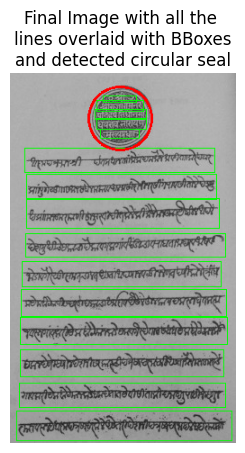

In [27]:
lines_main_text.extend(lines_seal_text)

final_image_lines_overlaid = draw_bounding_boxes(historical_doc_img, lines_main_text)

circles = np.uint16(np.around(circles))
for i in circles[0, :]:
    cv2.circle(final_image_lines_overlaid, (i[0], i[1]), i[2], (255, 0, 0), 2)  # Draw circumference (green)
    
plt.imshow(final_image_lines_overlaid)
plt.title("Final Image with all the \nlines overlaid with BBoxes\nand detected circular seal")
plt.axis("off")
plt.show()

> While detecting the lines within a seal there were various challenges faced which were not faced while detecting lines in the main part first of all we had to detect the seal itself which was done using hough circle detector, after detecting the seal I had to remove all the other things from the image except the seal with it's text and since the seal's text was in white color I had to completely invert the image to get the text in black, after only the text was remaining I used opening to make the distinction between lines more clear and then applied the same algorithm that was used for the main part of the text. While using that one issue encountered was about deciding the threshold of considering a spacing between lines because the number of black pixels that can be accomodated in each line decreases as the distance of the line increases with the center of the seal, hence coming up with a optimal value for that was the difficult part or applying a dynamic threshold values based on the distance from the center.

# 3.3

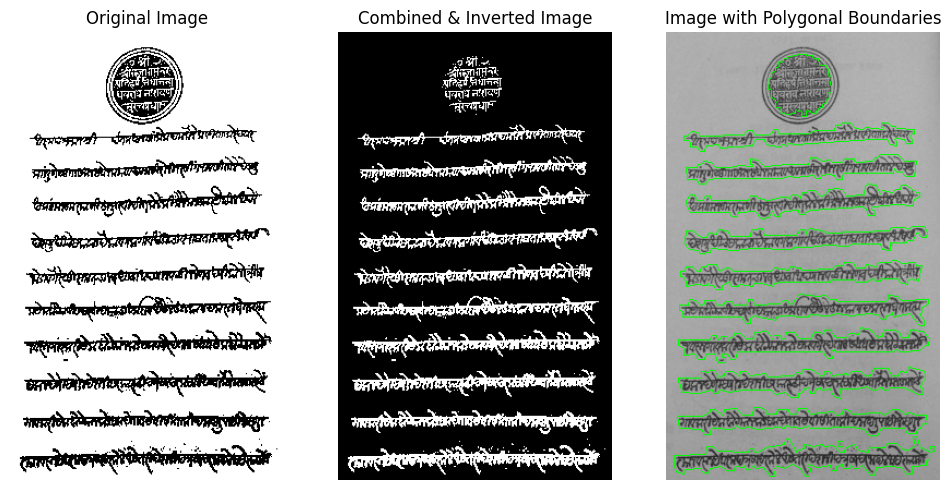

In [49]:
def detect_lines_with_polygons(image):

     # Apply dilation to enhance text regions
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    dilated = cv2.dilate(image, kernel, iterations=1)

    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a list to store the polygonal boundaries
    polygonal_boundaries = []
    
    for contour in contours:
        # Approximate the contour as a polygon
        epsilon = 0.002 * cv2.arcLength(contour, True)
        polygon = cv2.approxPolyDP(contour, epsilon, True)
        
        # Filter out small polygons based on area and number of vertices
        if cv2.contourArea(contour) > 10 and len(polygon) >= 0:
            polygonal_boundaries.append(polygon)
    
    return polygonal_boundaries

# preprocessed_img2 = np.astype(np.where(preprocessed_img == 255, 0, 255), np.uint8)

combined_image = np.bitwise_xor(np.astype(inverted_img, np.uint8), np.astype(cleared_img, np.uint8))

polygonal_boundaries = detect_lines_with_polygons(combined_image)

# Plot all the steps
fig, ax = plt.subplots(1, 3, figsize=(12, 8))

ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(combined_image, cmap='gray')
ax[1].set_title("Combined & Inverted Image")
ax[1].axis("off")

image_with_polygons = historical_doc_img.copy()
for polygon in polygonal_boundaries:
    cv2.polylines(image_with_polygons, [polygon], True, (0, 255, 0), 1)

ax[2].imshow(image_with_polygons)
ax[2].set_title("Image with Polygonal Boundaries")
ax[2].axis("off")

plt.show()

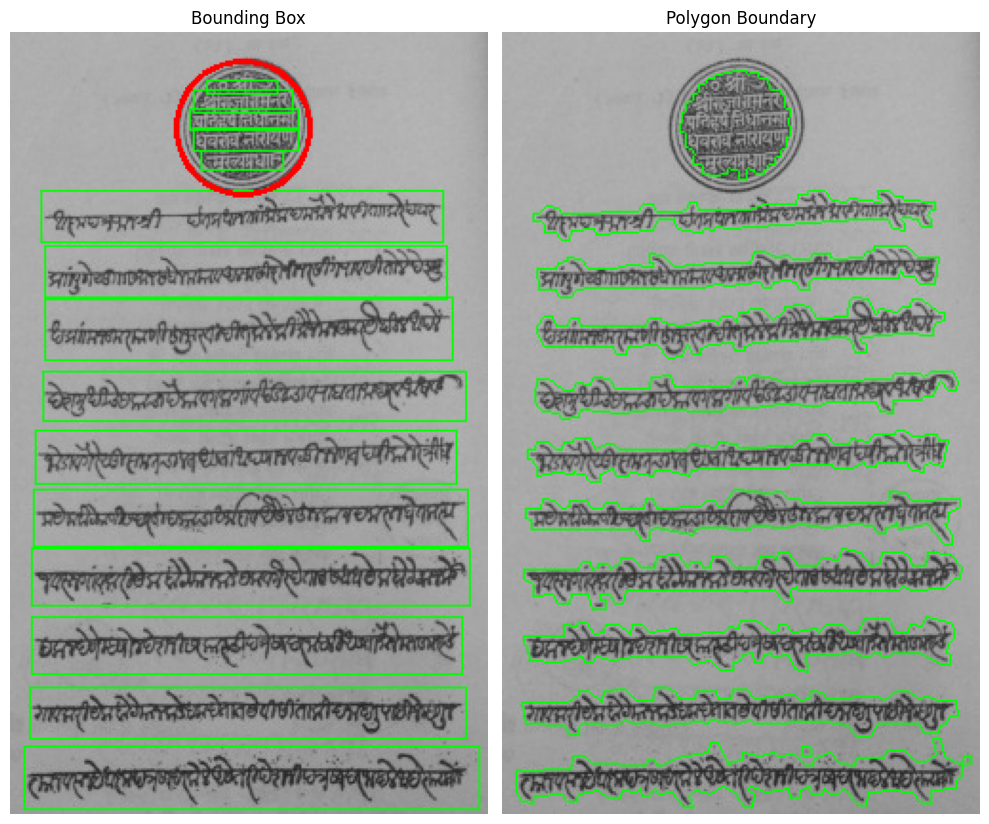

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(final_image_lines_overlaid)
ax[0].axis("off")
ax[0].set_title("Bounding Box")

ax[1].imshow(image_with_polygons)
ax[1].axis("off")
ax[1].set_title("Polygon Boundary")

plt.tight_layout()
plt.show()

> Rectangular bounding boxes are simple, fast, and work well when you only need to detect lines of text instead of individual characters or shapes. They require less computation and are better suited for tasks where accuracy in capturing the exact shape of the text isn't critical. However, they don’t handle irregular or curved text well, like the circular text or decorative historical script in the image, and often include extra background. Polygons, on the other hand, are much more precise as they can tightly follow the shape of the text, making them ideal for complex layouts. But polygons have their challenges—they struggle with smaller text chunks that are not clearly separated, often grouping them together as one large region. They also take more time and computational resources to process. For detecting lines or when speed is more important than accuracy, bounding boxes are the better option. However, for tasks requiring precise detection of irregular shapes, polygons are the superior choice.

> In the seal part for detecting the lines bounding boxes we used morphological opearation of opening which helped us mark lines with more black and have a clear distinction between lines but this method cannot be applied for polygonal boundary fitting as we need to fit the polygon to the original text itself and applying opening operation will lead to imperfect detection.